In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import requests
import json
import os
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

**Load in the WeRateDogs Twitter archive**

In [2]:
#Read in the We Rate Dogs Twitter Archive
arch_twt = pd.read_csv('twitter-archive-enhanced.csv')
arch_twt.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


**Programatically download image_predictions.tsv**

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(url.split('/')[-1], mode = 'wb') as file:
    file.write(response.content)

In [4]:
# Load the `image_predictions.tsv`
img_pred = pd.read_csv('image-predictions.tsv' , sep='\t')
img_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [5]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'GWq1H41I9eUtJBZFjJolllHMv'
consumer_secret = 'FCFlLv5cfWsNViev0LUnKhrSUnsI24mhDHca5NiRKMksqr5Qgq'
access_token = '1065486226881314816-Fc39DnO9RvhBlqwun8JFzZrYKyxxIp'
access_secret = 'yHcCtQxj2G0TlyMHoTFjLGdzh1zJOoLj7tCgYpLEGrWFU'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = arch_twt.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807

Success
1032: 745422732645535745
Success
1033: 745314880350101504
Success
1034: 745074613265149952
Success
1035: 745057283344719872
Success
1036: 744995568523612160
Success
1037: 744971049620602880
Success
1038: 744709971296780288
Success
1039: 744334592493166593
Success
1040: 744234799360020481
Success
1041: 744223424764059648
Success
1042: 743980027717509120
Success
1043: 743895849529389061
Success
1044: 743835915802583040
Success
1045: 743609206067040256
Success
1046: 743595368194129920
Success
1047: 743545585370791937
Success
1048: 743510151680958465
Success
1049: 743253157753532416
Success
1050: 743222593470234624
Success
1051: 743210557239623680
Success
1052: 742534281772302336
Success
1053: 742528092657332225
Success
1054: 742465774154047488
Success
1055: 742423170473463808
Success
1056: 742385895052087300
Success
1057: 742161199639494656
Success
1058: 742150209887731712
Success
1059: 741793263812808706
Success
1060: 741743634094141440
Success
1061: 741438259667034112
Success
10

Success
1281: 708834316713893888
Success
1282: 708810915978854401
Success
1283: 708738143638450176
Success
1284: 708711088997666817
Success
1285: 708479650088034305
Success
1286: 708469915515297792
Success
1287: 708400866336894977
Success
1288: 708356463048204288
Success
1289: 708349470027751425
Success
1290: 708149363256774660
Success
1291: 708130923141795840
Success
1292: 708119489313951744
Success
1293: 708109389455101952
Success
1294: 708026248782585858
Success
1295: 707995814724026368
Success
1296: 707983188426153984
Success
1297: 707969809498152960
Success
1298: 707776935007539200
Success
1299: 707741517457260545
Success
1300: 707738799544082433
Success
1301: 707693576495472641
Success
1302: 707629649552134146
Success
1303: 707610948723478529
Success
1304: 707420581654872064
Success
1305: 707411934438625280
Success
1306: 707387676719185920
Success
1307: 707377100785885184
Success
1308: 707315916783140866
Success
1309: 707297311098011648
Success
1310: 707059547140169728
Success
13

Success
1530: 690248561355657216
Success
1531: 690021994562220032
Success
1532: 690015576308211712
Success
1533: 690005060500217858
Success
1534: 689999384604450816
Success
1535: 689993469801164801
Success
1536: 689977555533848577
Success
1537: 689905486972461056
Success
1538: 689877686181715968
Success
1539: 689835978131935233
Success
1540: 689661964914655233
Success
1541: 689659372465688576
Success
1542: 689623661272240129
Success
1543: 689599056876867584
Success
1544: 689557536375177216
Success
1545: 689517482558820352
Success
1546: 689289219123089408
Success
1547: 689283819090870273
Success
1548: 689280876073582592
Success
1549: 689275259254616065
Success
1550: 689255633275777024
Success
1551: 689154315265683456
Success
1552: 689143371370250240
Success
1553: 688916208532455424
Success
1554: 688908934925697024
Success
1555: 688898160958271489
Success
1556: 688894073864884227
Success
1557: 688828561667567616
Success
1558: 688804835492233216
Success
1559: 688789766343622656
Success
15

Success
1779: 677895101218201600
Success
1780: 677716515794329600
Success
1781: 677700003327029250
Success
1782: 677698403548192770
Success
1783: 677687604918272002
Success
1784: 677673981332312066
Success
1785: 677662372920729601
Success
1786: 677644091929329666
Success
1787: 677573743309385728
Success
1788: 677565715327688705
Success
1789: 677557565589463040
Success
1790: 677547928504967168
Success
1791: 677530072887205888
Success
1792: 677335745548390400
Success
1793: 677334615166730240
Success
1794: 677331501395156992
Success
1795: 677328882937298944
Success
1796: 677314812125323265
Success
1797: 677301033169788928
Success
1798: 677269281705472000
Success
1799: 677228873407442944
Success
1800: 677187300187611136
Success
1801: 676975532580409345
Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
18

Success
2028: 671874878652489728
Success
2029: 671866342182637568
Success
2030: 671855973984772097
Success
2031: 671789708968640512
Success
2032: 671768281401958400
Success
2033: 671763349865160704
Success
2034: 671744970634719232
Success
2035: 671743150407421952
Success
2036: 671735591348891648
Success
2037: 671729906628341761
Success
2038: 671561002136281088
Success
2039: 671550332464455680
Success
2040: 671547767500775424
Success
2041: 671544874165002241
Success
2042: 671542985629241344
Success
2043: 671538301157904385
Success
2044: 671536543010570240
Success
2045: 671533943490011136
Success
2046: 671528761649688577
Success
2047: 671520732782923777
Success
2048: 671518598289059840
Success
2049: 671511350426865664
Success
2050: 671504605491109889
Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
20

Success
2277: 667443425659232256
Success
2278: 667437278097252352
Success
2279: 667435689202614272
Success
2280: 667405339315146752
Success
2281: 667393430834667520
Success
2282: 667369227918143488
Success
2283: 667211855547486208
Success
2284: 667200525029539841
Success
2285: 667192066997374976
Success
2286: 667188689915760640
Success
2287: 667182792070062081
Success
2288: 667177989038297088
Success
2289: 667176164155375616
Success
2290: 667174963120574464
Success
2291: 667171260800061440
Success
2292: 667165590075940865
Success
2293: 667160273090932737
Success
2294: 667152164079423490
Success
2295: 667138269671505920
Success
2296: 667119796878725120
Success
2297: 667090893657276420
Success
2298: 667073648344346624
Success
2299: 667070482143944705
Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
23

**Read tweet_json.txt line by line into a dataframe with tweet ID, retweet count, and favorite count.**

In [6]:
with open('tweet_json.txt', encoding='utf-8') as file:
    print(len(file.readlines()))

2333


In [7]:
# Create an empty list to load data line by line into it
df_list = []
with open('tweet_json.txt', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        data = json.loads(line)
        df_list.append(data)

In [8]:
# Convert the list to a dataframe and seperate out the variables of interest
df = pd.DataFrame(df_list, columns = df_list[0].keys())
tweet_count = df[['id', 'retweet_count', 'favorite_count']]

In [9]:
# Check if the dataframe is correctly extracted
tweet_count.head()

,id,retweet_count,favorite_count
0,892420643555336193,7852,36862
1,892177421306343426,5823,31727
2,891815181378084864,3850,23903
3,891689557279858688,8026,40179
4,891327558926688256,8671,38371


## Assessing the Data

In [10]:
# Visually assess arch_twt
arch_twt

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [11]:
# Visually assess img_pred
img_pred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [12]:
# Visually assess tweet_count
tweet_count

,id,retweet_count,favorite_count
0,892420643555336193,7852,36862
1,892177421306343426,5823,31727
2,891815181378084864,3850,23903
3,891689557279858688,8026,40179
4,891327558926688256,8671,38371
5,891087950875897856,2889,19305
6,890971913173991426,1905,11249
7,890729181411237888,17545,62144
8,890609185150312448,3982,26561
9,890240255349198849,6823,30401


In [13]:
# Check the detailed information of arch_twt
arch_twt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [14]:
# Check the last 5 rows of arch_twt
arch_twt.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [15]:
# Check the observations where expanded_urls is NaN
arch_twt[arch_twt.expanded_urls.isnull() == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [16]:
# Check if there are any erroneous datatypes
arch_twt.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [17]:
# Check the descriptive statistics for outliers and unusual stats
arch_twt.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


**Rating numerator and rating denominator seems to have unusual maxima and minima. So, let's check them first**

In [18]:
# Check the observation where rating numerator is maximum
arch_twt[arch_twt.rating_numerator == arch_twt.rating_numerator.max()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None


In [19]:
# Check the observation where rating denominator is maximum
arch_twt[arch_twt.rating_denominator == arch_twt.rating_denominator.max()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None


In [20]:
# Check the observations where rating numerator is greater than 20
arch_twt[arch_twt.rating_numerator > 20]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None


In [21]:
# Check the observations where rating denominator is other than 10
arch_twt[(arch_twt.rating_denominator > 10)|(arch_twt.rating_denominator < 10) ]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


**We must check whether the numerator values have been incorrectly entered due to wrong extraction of decimal values from the text**

In [22]:
# Check the numerator values where they have been incorrectly entered
pd.set_option('display.max_colwidth', 500)
arch_twt[arch_twt.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

,text,rating_numerator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5
340,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27
1689,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26


**Now, let's continue assessing further**

In [23]:
# Take the sample of 50 observations to get an overall idea
arch_twt.sample(50)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1982,672968025906282496,NaN,NaN,2015-12-05 02:37:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Gustaf. He's a purebred Chevy Equinox. Loves to shred. Gnarly lil pup. Great with the babes. 11/10 https://t.co/7CbO2eMAgJ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672968025906282496/photo/1,11,10,Gustaf,None,None,None,None
873,761334018830917632,NaN,NaN,2016-08-04 22:52:29 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bruce. I really want to hear the joke he was told. 10/10 for chuckle pup https://t.co/ErPLjjJOKc,NaN,NaN,NaN,https://twitter.com/dog_rates/status/761334018830917632/photo/1,10,10,Bruce,None,None,None,None
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,None,None,None,None
1044,743609206067040256,NaN,NaN,2016-06-17 01:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Stark. He just had his first ice cream cone. Got some on his nose. Requests your assistance. 10/10 would assist https://t.co/YwfN1lbpKA,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/743609206067040256/photo/1,https://twitter.com/dog_rates/status/743609206067040256/photo/1,https://twitter.com/dog_rates/status/743609206067040256/photo/1",10,10,Stark,None,None,None,None
1188,718454725339934721,NaN,NaN,2016-04-08 15:05:29 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This pic is old but I hadn't seen it until today and had to share. Creative af. 13/10 very good boy, would pet well https://t.co/4kD16wMA1Z",NaN,NaN,NaN,https://twitter.com/dog_rates/status/718454725339934721/photo/1,13,10,None,None,None,None,None
293,837820167694528512,NaN,NaN,2017-03-04 00:21:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Here's a pupper before and after being asked ""who's a good girl?"" Unsure as h*ck. 12/10 hint hint it's you https://t.co/ORiK6jlgdH",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/837820167694528512/photo/1,https://twitter.com/dog_rates/status/837820167694528512/photo/1",12,10,None,None,None,pupper,None
2110,670444955656130560,NaN,NaN,2015-11-28 03:31:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Paull. He just stubbed his toe. 10/10 deep breaths Paull https://t.co/J5Mqn8VeYq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670444955656130560/photo/1,10,10,Paull,None,None,None,None
2272,667491009379606528,NaN,NaN,2015-11-19 23:53:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Two dogs in this one. Both are rare Jujitsu Pythagoreans. One slightly whiter than other. Long legs. 7/10 and 8/10 https://t.co/ITxxcc4v9y,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667491009379606528/photo/1,7,10,None,None,None,None,None
1519,690735892932222976,NaN,NaN,2016-01-23 03:20:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Peaches. She's a Dingleberry Zanderfloof. 13/10 would caress lots https://t.co/YrhkrTsoTt,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/690735892932222976/photo/1,https://twitter.com/dog_rates/status/690735892932222976/photo/1",13,10,Peaches,None,None,None,None
799,772826264096874500,NaN,NaN,2016-09-05 15:58:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Roosevelt. He

In [24]:
# Check if there are any duplicated tweet ids
arch_twt[arch_twt.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [25]:
arch_twt.drop_duplicates("tweet_id",keep=False,inplace=True)

In [26]:
# Check if there are any duplicated tweet ids
arch_twt[arch_twt.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [27]:
# Check the individual value counts for each value of source column
arch_twt.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [28]:
# Check those observations where retweeted_status_id or retweeted_status_user_id are not null
arch_twt[(arch_twt.retweeted_status_id.isnull() == False) | (arch_twt.retweeted_status_user_id.isnull() == False)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397445533696/photo/1,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,"https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1",14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" re

In [29]:
# Check those observations where in_reply_to_status_id or in_reply_to_user_id are not null
arch_twt[(arch_twt.in_reply_to_status_id.isnull() == False) | (arch_twt.in_reply_to_user_id.isnull() == False)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen",NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547188785154/photo/1,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610513747968/photo/1,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


In [30]:
# Check the detailed information of img_pred table
img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [31]:
# Check the descriptive statistics of img_pred for any outliers and unusual stats
img_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [32]:
# Check the distribution of img_num values
img_pred.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [33]:
# Check the observations where p1_conf = 1
img_pred[(img_pred.p1_conf == 1.0)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
106,667866724293877760,https://pbs.twimg.com/media/CUS9PlUWwAANeAD.jpg,1,jigsaw_puzzle,1.0,False,prayer_rug,1.011300e-08,False,doormat,1.740170e-10,False


In [34]:
# Take the sample of 50 observations to get an overall idea
img_pred.sample(50)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
1022,710272297844797440,https://pbs.twimg.com/media/Cdtk414WoAIUG0v.jpg,1,Old_English_sheepdog,0.586307,True,wire-haired_fox_terrier,0.118622,True,Lakeland_terrier,0.106806,True
1794,831309418084069378,https://pbs.twimg.com/media/C4lngK5VUAEVrNO.jpg,1,Doberman,0.369389,True,kelpie,0.132449,True,Labrador_retriever,0.074727,True
206,669926384437997569,https://pbs.twimg.com/media/CUwOfnDWcAIXryP.jpg,1,Pomeranian,0.984231,True,keeshond,0.010231,True,papillon,0.002219,True
241,670444955656130560,https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg,1,English_springer,0.403698,True,Brittany_spaniel,0.347609,True,Welsh_springer_spaniel,0.137186,True
1872,844979544864018432,https://pbs.twimg.com/media/C7n4aQ0VAAAohkL.jpg,3,tennis_ball,0.999281,False,racket,0.000370,False,Shetland_sheepdog,0.000132,True
1360,761004547850530816,https://pbs.twimg.com/media/Co-hmcYXYAASkiG.jpg,1,golden_retriever,0.735163,True,Sussex_spaniel,0.064897,True,Labrador_retriever,0.047704,True
1916,854482394044301312,https://pbs.twimg.com/media/C9u7MtmV0AA741s.jpg,1,Chihuahua,0.260242,True,toy_poodle,0.189158,True,Labrador_retriever,0.144195,True
1217,743595368194129920,https://pbs.twimg.com/media/ClHICHmXEAI_1PS.jpg,1,hippopotamus,0.505675,False,hog,0.370726,False,warthog,0.018827,False
475,675149409102012420,https://pbs.twimg.com/media/CV6czeEWEAEdChp.jpg,1,chow,0.999876,True,Tibetan_mastiff,0.000059,True,Tibetan_terrier,0.000029,True


In [35]:
# Check if there are any duplicated tweet ids
img_pred[img_pred.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [36]:
# Check if there are any duplicated jpg_url
img_pred[img_pred.jpg_url.duplicated()].jpg_url.values

array(['https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg',
       'https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg',
       'https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg',
       'https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg',
       'https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg',
       'https://pbs.twimg.com/tweet_video_thumb/CeBym7oXEAEWbEg.jpg',
       'https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg',
       'https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg',
       'https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg',
       'https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg',
       'https://pbs.twimg.com/media/Cp6db4-XYAAMmqL.jpg',
       'https://pbs.twimg.com/media/CiyHLocU4AI2pJu.jpg',
       'https://pbs.twimg.com/media/CW88XN4WsAAlo8r.jpg',
       'https://pbs.twimg.com/media/CmoPdmHW8AAi8BI.jpg',
       'https://pbs.twimg.com/media/CcG07BYW0AErrC9.jpg',
       'https://pbs.twimg.com/media/Ck2d7tJWUAEPTL3.jpg',
       'https://pbs.

In [37]:
# Check fr all the duplicates of jpg_url
img_pred[img_pred.jpg_url.apply(lambda x: x in img_pred[img_pred.jpg_url.duplicated()].jpg_url.values)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
85,667509364010450944,https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg,1,beagle,0.636169,True,Labrador_retriever,0.119256,True,golden_retriever,0.082549,True
224,670319130621435904,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
241,670444955656130560,https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg,1,English_springer,0.403698,True,Brittany_spaniel,0.347609,True,Welsh_springer_spaniel,0.137186,True
327,671896809300709376,https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg,1,chow,0.243529,True,hamster,0.227150,False,Pomeranian,0.056057,True
382,673320132811366400,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True
432,674291837063053312,https://pbs.twimg.com/media/CVuQ2LeUsAAIe3s.jpg,1,Cardigan,0.611525,True,Pembroke,0.368566,True,Chihuahua,0.003330,True
480,675354435921575936,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
487,675501075957489664,https://pbs.twimg.com/media/CV_cnjHWUAADc-c.jpg,1,dough,0.806757,False,bakery,0.027907,False,French_loaf,0.018189,False
587,679062614270468097,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
591,679158373988876288,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False


### tweet_count table :

In [38]:
# Check the detailed info of tweet_count
tweet_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 3 columns):
id                2333 non-null int64
retweet_count     2333 non-null int64
favorite_count    2333 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


In [39]:
# Check the descriptive statistics of tweet_count for any outliers and unusual stats
tweet_count.describe()

,id,retweet_count,favorite_count
count,2.333000e+03,2333.000000,2333.000000
mean,7.419279e+17,2766.747535,7687.977282
std,6.820607e+16,4682.621925,11932.901172
min,6.660209e+17,1.000000,0.000000
25%,6.782786e+17,555.000000,1335.000000
50%,7.184547e+17,1297.000000,3344.000000
75%,7.986654e+17,3217.000000,9441.000000
max,8.924206e+17,79458.000000,159218.000000


In [40]:
# Check for the duplicate observations
tweet_count[tweet_count.duplicated() == True]

,id,retweet_count,favorite_count


In [41]:
# Check if there are any duplicate ids
tweet_count[tweet_count.id.duplicated()]

,id,retweet_count,favorite_count


In [42]:
# Check for the instances where retweet_count and favorite_count are duplicated together
tweet_count[(tweet_count.retweet_count.duplicated()) & (tweet_count.favorite_count.duplicated())]

,id,retweet_count,favorite_count
213,849668094696017920,4947,0
305,834477809192075265,10914,0
518,807059379405148160,7664,0
526,805958939288408065,5598,0
780,772615324260794368,3496,0
808,768909767477751808,2770,0
826,766078092750233600,2707,0
839,763167063695355904,3114,0
847,761750502866649088,4031,0
867,759846353224826880,2031,6882


**Below, I have mentioned all the Quality and Tidiness issues**

## Quality
### arch_twt table - Twitter's archive
- There are many columns with missing values namely - in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls
- name, doggo, floofer, pupper and puppo columns have value with the name `None`
- Values in `source` column are not human readable
- Some names in the `name` column are invalid data like `such`, `quite`, `a`, `an`
- Erroneous data types - `timestamp` & `retweeted_status_timestamp` column(also needs to be split into two date and time); `dog_stage` column(should be categorical); `tweet_id`, `in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id` columns(should be str)
- `rating_denominator` is other than assumed standard value of `10` at some places which can be Inaccurate data
- `rating_numerator` column has some exceptionally high values which leads to exceptionally high rating which can be inaccurate
- There are 6 instances of incorrectly entered `rating_numerator` values
- There are some tweets which are retweets to `@dog_rates` which is the twitter handle for `We Rate Dogs`

### img_pred table - Image predictions
- Use of `_` instead of `space` in p1, p2 and p3 column values. Also, values upper case sometimes lowercase other times in p1, p2 and p3 columns
- column names are not clearly descriptive
- There are image duplicate predictions present for duplicate `jpg_url` with different tweet ids and rest all the data same.

### tweet_count - retweet count and favorite count
- tweet id title is different, `id` here `tweet_id` in others.
- Both `retweet_count` and `favorite_count` values are duplicated in some rows(doubtful)

## Tidiness
### arch_twt table - Twitter's archive
- One variable in 4 columns - dog_stage(doggo, floofer, pupper, puppo)
- Merge the tables - `arch_twt` and `tweet_count`

## Cleaning Data

## Missing Data
**We will work through the cleaning process through three steps:**

1. **Define:** We will convert our assessments into defined cleaning tasks. These definitions also serve as an instruction list so others (or we in the future) can look at our work and reproduce it.
2. **Code:** We will convert those definitions to code and run that code.
3. **Test:** We will test our dataset, visually or with code, to make sure our cleaning operations worked.

I will follow the following plan for this section so that we don't need to use the repetitive codes in the future:

**1. Missing Data**

**2. Tidiness Issues** 

**3. Other Quality Issues**

Let's take down the issues one by one

In [43]:
# Create copies of the above three dataframes
tweet_data_clean = arch_twt.copy()
img_pred_clean = img_pred.copy()
tweet_count_clean = tweet_count.copy()

**Code**

In [44]:
# Drop the unnecessary columns
tweet_data_clean = tweet_data_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_user_id'], axis=1)

In [45]:
# Fill the missing values
tweet_data_clean.expanded_urls = 'https://twitter.com/dog_rates/status/' + tweet_data_clean.tweet_id.astype(str) 

In [46]:
# Drop retweeted_status_timestamp
tweet_data_clean = tweet_data_clean.drop('retweeted_status_timestamp', axis=1)

**Test**

In [47]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id               2356 non-null int64
timestamp              2356 non-null object
source                 2356 non-null object
text                   2356 non-null object
retweeted_status_id    181 non-null float64
expanded_urls          2356 non-null object
rating_numerator       2356 non-null int64
rating_denominator     2356 non-null int64
name                   2356 non-null object
doggo                  2356 non-null object
floofer                2356 non-null object
pupper                 2356 non-null object
puppo                  2356 non-null object
dtypes: float64(1), int64(3), object(9)
memory usage: 257.7+ KB


In [48]:
tweet_data_clean[tweet_data_clean.expanded_urls.isnull() == True]

,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


## Tidiness Issues

**Code**

In [49]:
# Replace the NaNs with empty string
tweet_data_clean[['doggo', 'floofer', 'pupper', 'puppo']] = tweet_data_clean[['doggo', 'floofer', 'pupper', 'puppo']].replace('None', '')

In [50]:
# Combine the columns into one column
tweet_data_clean['dog_stage'] = tweet_data_clean['doggo'] + tweet_data_clean['floofer'] + tweet_data_clean['pupper'] + tweet_data_clean['puppo']

In [51]:
# Drop unnecessary columns
tweet_data_clean = tweet_data_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

In [52]:
tweet_data_clean.dog_stage.value_counts()

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggofloofer       1
doggopuppo         1
Name: dog_stage, dtype: int64

In [53]:
tweet_data_clean.dog_stage = tweet_data_clean.dog_stage.replace('doggopupper', 'multiple')
tweet_data_clean.dog_stage = tweet_data_clean.dog_stage.replace('doggopuppo', 'multiple')
tweet_data_clean.dog_stage = tweet_data_clean.dog_stage.replace('doggofloofer', 'multiple')

**Test**

In [54]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id               2356 non-null int64
timestamp              2356 non-null object
source                 2356 non-null object
text                   2356 non-null object
retweeted_status_id    181 non-null float64
expanded_urls          2356 non-null object
rating_numerator       2356 non-null int64
rating_denominator     2356 non-null int64
name                   2356 non-null object
dog_stage              2356 non-null object
dtypes: float64(1), int64(3), object(6)
memory usage: 202.5+ KB


In [55]:
tweet_data_clean.dog_stage.value_counts()

            1976
pupper       245
doggo         83
puppo         29
multiple      14
floofer        9
Name: dog_stage, dtype: int64

**tweet id title is different, id here tweet_id in others.**

**Code**

In [56]:
tweet_count_clean = tweet_count_clean.rename(columns = {'id': 'tweet_id'})

**Test**

In [57]:
list(tweet_count_clean)

['tweet_id', 'retweet_count', 'favorite_count']

**Merge the tables - arch_twt and tweet_count**

**Code**

In [58]:
tweet_data_clean = pd.merge(tweet_data_clean, tweet_count_clean, on = 'tweet_id', how = 'inner')

**Test**

In [59]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2332
Data columns (total 12 columns):
tweet_id               2333 non-null int64
timestamp              2333 non-null object
source                 2333 non-null object
text                   2333 non-null object
retweeted_status_id    165 non-null float64
expanded_urls          2333 non-null object
rating_numerator       2333 non-null int64
rating_denominator     2333 non-null int64
name                   2333 non-null object
dog_stage              2333 non-null object
retweet_count          2333 non-null int64
favorite_count         2333 non-null int64
dtypes: float64(1), int64(5), object(6)
memory usage: 236.9+ KB


## Quality Issues

### tweet_data_clean table:

**Code**

In [60]:
# Convert timestamp datatype to datetime
tweet_data_clean.timestamp = pd.to_datetime(tweet_data_clean.timestamp)

In [61]:
# Seperate out the series of retweeted_status_id to match later
retweet_clean = tweet_data_clean.retweeted_status_id

retweet_clean = retweet_clean.dropna()

retweet_clean = retweet_clean.astype('int64')

In [62]:
# Drop the observations where tweet_id matches the above seperated series
tweet_data_clean = tweet_data_clean.drop(tweet_data_clean[tweet_data_clean.tweet_id.apply(lambda x : x in retweet_clean.values)].index.values, axis=0)



In [63]:
tweet_data_clean = tweet_data_clean.drop('retweeted_status_id', axis=1)

**Test**

In [64]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2227 entries, 0 to 2332
Data columns (total 11 columns):
tweet_id              2227 non-null int64
timestamp             2227 non-null datetime64[ns, UTC]
source                2227 non-null object
text                  2227 non-null object
expanded_urls         2227 non-null object
rating_numerator      2227 non-null int64
rating_denominator    2227 non-null int64
name                  2227 non-null object
dog_stage             2227 non-null object
retweet_count         2227 non-null int64
favorite_count        2227 non-null int64
dtypes: datetime64[ns, UTC](1), int64(5), object(5)
memory usage: 208.8+ KB


**rating_denominator is other than assumed standard value of 10 at some places which can be Inaccurate data and there are 6 instances of incorrectly entered rating_numerator values**

**Code:**

In [65]:
# Check for the instances where rating_denominator is other than 10
pd.set_option('display.max_colwidth', 200)
tweet_data_clean[['text','expanded_urls', 'rating_numerator', 'rating_denominator']].query('rating_denominator != 10')

,text,expanded_urls,rating_numerator,rating_denominator
299,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",https://twitter.com/dog_rates/status/835246439529840640,960,0
328,@docmisterio account started on 11/15/15,https://twitter.com/dog_rates/status/832088576586297345,11,15
417,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,https://twitter.com/dog_rates/status/820690176645140481,84,70
499,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,https://twitter.com/dog_rates/status/810984652412424192,24,7
881,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024,165,150
1046,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",https://twitter.com/dog_rates/status/740373189193256964,9,11
1098,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288,204,170
1143,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656,4,20
1180,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801,50,50
1206,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249,99,90


In [66]:
# Check the numerator values where they have been incorrectly entered
pd.set_option('display.max_colwidth', 500)
tweet_data_clean[tweet_data_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
44,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
326,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
744,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
1667,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5,10
1690,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


In [67]:
# Replace the incorrect ratings with correct ratings
tweet_data_clean[['rating_numerator', 'rating_denominator']] = tweet_data_clean[['rating_numerator', 'rating_denominator']].replace([960 ,0], [13, 10])

In [68]:
# Replace the incorrect ratings with correct ratings
tweet_data_clean.loc[783, 'rating_numerator':'rating_denominator'] = [14, 10]

tweet_data_clean.loc[1066, 'rating_numerator':'rating_denominator'] = [14, 10]

tweet_data_clean.loc[1163, 'rating_numerator':'rating_denominator'] = [13, 10]

tweet_data_clean.loc[1200, 'rating_numerator':'rating_denominator'] = [11, 10]

tweet_data_clean.loc[1596, 'rating_numerator':'rating_denominator'] = [13, 10]

tweet_data_clean.loc[1660, 'rating_numerator':'rating_denominator'] = [10, 10]

tweet_data_clean.loc[2333, 'rating_numerator':'rating_denominator'] = [9, 10]

tweet_data_clean.loc[44, 'rating_numerator':'rating_denominator'] = [13.50, 10]

tweet_data_clean.loc[339, 'rating_numerator':'rating_denominator'] = [9.75, 10]

tweet_data_clean.loc[762, 'rating_numerator':'rating_denominator'] = [11.27, 10]

tweet_data_clean.loc[1687, 'rating_numerator':'rating_denominator'] = [9.50, 10]

tweet_data_clean.loc[1710, 'rating_numerator':'rating_denominator'] = [11.26, 10]

In [69]:
# Drop the other wrongly entered ratings
tweet_data_clean = tweet_data_clean.drop([341, 515, 783, 1596, 1661], axis = 0)

In [70]:
# Check the datatype of each variable
tweet_data_clean.dtypes

tweet_id                          float64
timestamp             datetime64[ns, UTC]
source                             object
text                               object
expanded_urls                      object
rating_numerator                  float64
rating_denominator                float64
name                               object
dog_stage                          object
retweet_count                     float64
favorite_count                    float64
dtype: object

In [71]:
# Create a rating_factor column 
tweet_data_clean['rating_factor'] = tweet_data_clean.rating_denominator/10

# Change the rating_denominator to 10 and rating_numerator equivalent to 10 using rating_factor variable
tweet_data_clean.rating_denominator = (tweet_data_clean.rating_denominator/tweet_data_clean['rating_factor']).astype('int64')
tweet_data_clean.rating_numerator = (tweet_data_clean.rating_numerator/tweet_data_clean['rating_factor'])

In [72]:
# Drop the rating_factor
tweet_data_clean.drop('rating_factor', axis=1, inplace=True)

**Test**

In [73]:
tweet_data_clean.query('rating_denominator != 10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count


In [74]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223 entries, 0 to 2333
Data columns (total 11 columns):
tweet_id              2222 non-null float64
timestamp             2222 non-null datetime64[ns, UTC]
source                2222 non-null object
text                  2222 non-null object
expanded_urls         2222 non-null object
rating_numerator      2223 non-null float64
rating_denominator    2223 non-null int64
name                  2222 non-null object
dog_stage             2222 non-null object
retweet_count         2222 non-null float64
favorite_count        2222 non-null float64
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(5)
memory usage: 208.4+ KB


**Some names in the `name` column are invalid data like `such`, `quite`, `a`, `an`**

**Code**:

In [75]:
# Check for invalid names
tweet_data_clean[tweet_data_clean.name.str.islower() == True].name.value_counts()

a               55
the              8
an               6
very             5
one              4
quite            3
just             3
actually         2
not              2
getting          2
old              1
incredibly       1
his              1
officially       1
such             1
unacceptable     1
all              1
infuriating      1
this             1
life             1
my               1
by               1
mad              1
space            1
light            1
Name: name, dtype: int64

In [76]:
# Replace the invalid names with a string 'None'
for item in tweet_data_clean.name:
    if str(item).islower() == True:
        tweet_data_clean.name = tweet_data_clean.name.replace(item, 'None')

In [77]:
tweet_data_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count
0,8.924206e+17,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193,13.0,10,Phineas,,7852.0,36862.0
1,8.921774e+17,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426,13.0,10,Tilly,,5823.0,31727.0
2,8.918152e+17,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864,12.0,10,Archie,,3850.0,23903.0
3,8.916896e+17,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688,13.0,10,Darla,,8026.0,40179.0
4,8.913276e+17,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",https://twitter.com/dog_rates/status/891327558926688256,12.0,10,Franklin,,8671.0,38371.0
5,8.910880e+17,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856,13.0,10,None,,2889.0,19305.0
6,8.909719e+17,2017-07-28 16:27:12+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,https://twitter.com/dog_rates/status/890971913173991426,13.0,10,Jax,,1905.0,11249.0
7,8.907292e+17,2017-07-28 00:22:40+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,https://twitter.com/dog_rates/status/890729181411237888,13.0,10,None,,17545.0,62144.0
8,8.906092e+17,2017-07-27 16:25:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448,13.0,10,Zoey,,3982.0,26561.0
9,8.902403e+17,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,https://twitter.com/dog_rates/status/890240255349198849,14.0,10,Cassie,doggo,6823.0,30401.0


In [78]:
# Replace 'None' string in the name column with NaN value
tweet_data_clean.name = tweet_data_clean.name.replace('None', np.nan)

**Test**

In [79]:
tweet_data_clean[tweet_data_clean.name.str.islower() == True].name

Series([], Name: name, dtype: object)

In [80]:
sum(tweet_data_clean.name.isnull())

808

**name, doggo, floofer, pupper and puppo columns have value with the name None**

**Code**:

In [81]:
# Check the distribution of each value in the dog_stage
tweet_data_clean.dog_stage.value_counts()

            1872
pupper       229
doggo         76
puppo         24
multiple      12
floofer        9
Name: dog_stage, dtype: int64

In [82]:
# Take the sample of the data with text and dog_stage variables to get an overall idea
pd.set_option('display.max_colwidth', 200)
tweet_data_clean[['text', 'dog_stage']].sample(50)

,text,dog_stage
1541,This is Lizzie. She's about to fist bump the large ridable maned pupper. She's very excited. 10/10 for both dogs https://t.co/mFhvtX36om,pupper
538,RT @dog_rates: I present to you... Dog Jesus. 13/10 (he could be sitting on a rock but I doubt it) https://t.co/fR1P3g5I6k,
751,RT @dog_rates: Everybody look at this beautiful pupper 13/10 https://t.co/hyAC5Hq9GC,pupper
1192,This is Michelangelope. He's half coffee cup. Rare af. 12/10 would hug until someone stopped me https://t.co/tvVDY0G911,
101,This is Kody. He's a baller. Wishes he was a little bit taller. Double dribbles often. Still 12/10 would happily get dunked on https://t.co/PKSpmiefwN,
736,"This is Mya (pronounced ""mmmyah?""). Her head is round af. 11/10 would pat accordingly https://t.co/1dpEuALnY0",
267,Meet Sojourner. His nose is a Fibonacci Spiral. Legendary af. 13/10 we must protect him at all costs https://t.co/r7W1NbkOtr,
339,This is Scooter and his son Montoya. Scooter is a wonderful father. He takes very good care of Montoya. Both 12/10 would pet at same time https://t.co/ghqMfxxa4V,
1393,This is Rusty. He has no respect for POULTRY products. Unbelievable af. 7/10 would still pet https://t.co/hEH19t1eFp,
1699,This is Reggie. His Santa hat is a little big. 10/10 he's still having fun https://t.co/w0dcGXq7qK,


In [83]:
# Collect the correct words for dog_stage interpretation in 4 variables for seperating 4 different dog_stages 
dog_pupper = ['Pup', 'pup', 'pups', 'puppers', 'pupper', 'Pupper', 'puppeters', 'puppy', 'Puppy', 'Pup.', 'pup.', 'pups.', 'puppers.', 'pupper.', 'Pupper.', 'puppeters.', 'puppy.', 'Puppy.', 'pupper,', 'pupper?', '(pupper)', 'PUPPER', '(pupper).']
dog_doggo = ['Doggo', 'doggo', 'dogg', 'Doggo.', 'doggo.', 'dogg.', 'doggo?', '(doggo)', 'DOGGO', '(doggo),']
dog_puppo = ['puppo', 'Puppo', 'puppo.', 'Puppo.', 'puppo?']
dog_floofer = ['Floofer', 'floofs', 'floofer', 'floofers', 'floof', 'Floofy', 'floofy', 'floofs.', 'floofer.', 'floofers.', 'floof.', 'Floofy.', 'floofy.', 'Floofer.']

In [84]:
# Form a new column to test
tweet_data_clean['dog_stage_2'] = ''

In [85]:
# Use the above 4 variables to correctly interpret dog stage in the new column
for item in tweet_data_clean.text:
    y = tweet_data_clean[tweet_data_clean.text == item].index.values
    x = str(item).strip(".,").split(' ')
    for word in x:
        if (word in dog_pupper) and (word in dog_doggo):
            tweet_data_clean.loc[y, 'dog_stage_2'] = 'pupper & doggo'
        elif (word in dog_puppo) and (word in dog_doggo):
            tweet_data_clean.loc[y, 'dog_stage_2'] = 'puppo & doggo'
        elif (word in dog_floofer) and (word in dog_doggo):
            tweet_data_clean.loc[y, 'dog_stage_2'] = 'floofer & doggo'
        elif word in dog_pupper:
            tweet_data_clean.loc[y, 'dog_stage_2'] = 'pupper'
        elif word in dog_doggo:
            tweet_data_clean.loc[y, 'dog_stage_2'] = 'doggo'
        elif word in dog_puppo:
            tweet_data_clean.loc[y, 'dog_stage_2'] = 'puppo'
        elif word in dog_floofer:
            tweet_data_clean.loc[y, 'dog_stage_2'] = 'floofer'

In [86]:
# Replace the dog_stage column with the new column values
tweet_data_clean.dog_stage = tweet_data_clean.dog_stage_2

In [87]:
# Drop the new column and replace instances of empty string with NaN
tweet_data_clean.dog_stage = tweet_data_clean.dog_stage.replace('', np.nan)
tweet_data_clean.drop('dog_stage_2', axis=1, inplace=True)

**Test**

In [88]:
tweet_data_clean.dog_stage.value_counts()

pupper     411
doggo       76
puppo       23
floofer     20
Name: dog_stage, dtype: int64

In [89]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223 entries, 0 to 2333
Data columns (total 11 columns):
tweet_id              2222 non-null float64
timestamp             2222 non-null datetime64[ns, UTC]
source                2222 non-null object
text                  2222 non-null object
expanded_urls         2222 non-null object
rating_numerator      2223 non-null float64
rating_denominator    2223 non-null int64
name                  1415 non-null object
dog_stage             530 non-null object
retweet_count         2222 non-null float64
favorite_count        2222 non-null float64
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(5)
memory usage: 288.4+ KB


**Values in source column are not human readable**

**Code**:

In [90]:
# Check the distribution of source values 
tweet_data_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2101
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          80
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

In [91]:
# Replace the values in the source column with human readable text
tweet_data_clean.source = tweet_data_clean.source.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'Twitter for iPhone')
tweet_data_clean.source = tweet_data_clean.source.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>', 'Vine - Make a Scene')
tweet_data_clean.source = tweet_data_clean.source.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'Twitter Web Client')
tweet_data_clean.source = tweet_data_clean.source.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'TweetDeck')

**Test**

In [92]:
tweet_data_clean.source.value_counts()

Twitter for iPhone     2101
Vine - Make a Scene      80
Twitter Web Client       31
TweetDeck                10
Name: source, dtype: int64

## img_pred_clean table:

**Use of _ instead of space in p1, p2 and p3 column values. Also, values upper case sometimes lowercase other times in p1, p2 and p3 columns**

**Code**:

In [93]:
img_pred_clean.p1 = img_pred_clean.p1.str.replace('_', ' ').str.capitalize()
img_pred_clean.p2 = img_pred_clean.p2.str.replace('_', ' ').str.capitalize()
img_pred_clean.p3 = img_pred_clean.p3.str.replace('_', ' ').str.capitalize()

**Test**

In [94]:
img_pred_clean[['p1', 'p2', 'p3']].sample(50)

,p1,p2,p3
965,Papillon,Pekinese,Saint bernard
158,Teddy,Pillow,Miniature schnauzer
720,Papillon,Toy terrier,Cardigan
668,Boxer,Bull mastiff,French bulldog
1662,Staffordshire bullterrier,French bulldog,Doormat
246,Wool,Siamang,Gorilla
377,Schipperke,Groenendael,Kelpie
1996,Labrador retriever,Staffordshire bullterrier,Beagle
1320,Conch,French bulldog,Tiger cat
84,Labrador retriever,Golden retriever,Beagle


**column names are not clearly descriptive**

**Code**:

In [95]:
img_pred_clean = img_pred_clean.rename(columns = {'jpg_url':'image_url', 'img_num':'image_number', 'p1':'first_prediction', 'p2':'second_prediction', 'p3':'third_prediction', 'p1_conf':'first_prediction_confidence', 'p2_conf':'second_prediction_confidence', 'p3_conf':'third_prediction_confidence', 'p1_dog':'first_prediction_dog', 'p2_dog':'second_prediction_dog', 'p3_dog':'third_prediction_dog'})

**Test**

In [96]:
list(img_pred_clean)

['tweet_id',
 'image_url',
 'image_number',
 'first_prediction',
 'first_prediction_confidence',
 'first_prediction_dog',
 'second_prediction',
 'second_prediction_confidence',
 'second_prediction_dog',
 'third_prediction',
 'third_prediction_confidence',
 'third_prediction_dog']

**There are image duplicate predictions present for duplicate jpg_url with different tweet ids and rest all the data same.**

**Code**:

In [97]:
img_pred_clean = img_pred_clean.drop_duplicates(['image_url'])

**Test**

In [98]:
img_pred_clean[img_pred_clean.image_url.duplicated()]

,tweet_id,image_url,image_number,first_prediction,first_prediction_confidence,first_prediction_dog,second_prediction,second_prediction_confidence,second_prediction_dog,third_prediction,third_prediction_confidence,third_prediction_dog


In [99]:
img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id                        2009 non-null int64
image_url                       2009 non-null object
image_number                    2009 non-null int64
first_prediction                2009 non-null object
first_prediction_confidence     2009 non-null float64
first_prediction_dog            2009 non-null bool
second_prediction               2009 non-null object
second_prediction_confidence    2009 non-null float64
second_prediction_dog           2009 non-null bool
third_prediction                2009 non-null object
third_prediction_confidence     2009 non-null float64
third_prediction_dog            2009 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 162.8+ KB


## STORING THE DATA

### 1. Storing tweet_data_clean

In [100]:
tweet_data_master = pd.merge(tweet_data_clean, img_pred_clean, on = 'tweet_id', how = 'inner')

In [101]:
tweet_data_master.to_csv('twitter_archive_master.csv')

### 2. Storing img_pred_clean

In [102]:
img_pred_clean.to_csv('image_predictions_master.csv')

<a id = 'analyse'></a>
## ANALYSING THE DATA

Now, here, I am analyzing the data on 3 different questions of interest

### 1. Comparison Of Average Number Of Retweets And Favorites In A Month

In [103]:
# Create a subset of the tweet_data_clean with the required variables
tweets_month = tweet_data_clean[['tweet_id', 'timestamp', 'retweet_count', 'favorite_count']]

In [104]:
# Create a months column using timestamp variable
tweets_month['month'] = tweet_data_clean['timestamp'].dt.month 

In [105]:
# Check if the above methods are applied correctly
tweets_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223 entries, 0 to 2333
Data columns (total 5 columns):
tweet_id          2222 non-null float64
timestamp         2222 non-null datetime64[ns, UTC]
retweet_count     2222 non-null float64
favorite_count    2222 non-null float64
month             2222 non-null float64
dtypes: datetime64[ns, UTC](1), float64(4)
memory usage: 184.2 KB


In [106]:
# Create a variable for storing mean of retweet counts grouped by month
avg_retweets = tweets_month.sort_values('month').groupby('month').retweet_count.mean().astype(int)

In [107]:
# Create a variable for storing mean of favorite counts grouped by month
avg_favorites = tweets_month.sort_values('month').groupby('month').favorite_count.mean().astype(int)

In [108]:
# Define the locations and width for the bar graphs
index = np.arange(len(avg_retweets))
width = 0.4

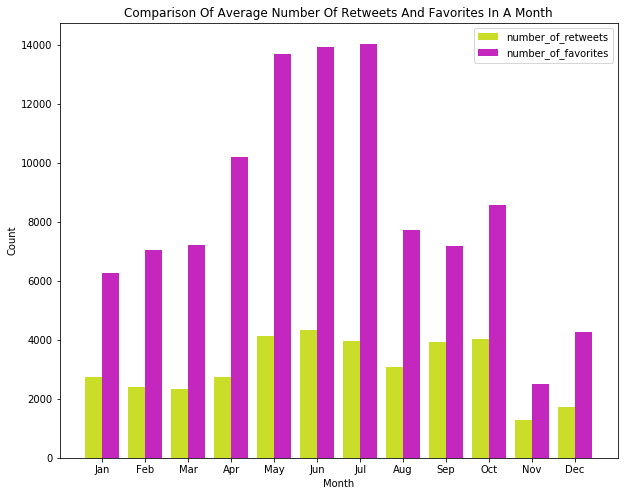

In [109]:
# two bar graphs settled in one
plt.figure(figsize = (10, 8))
retweet_bars = plt.bar(index, avg_retweets, width, alpha = 1, color = '#CADD29', label = 'number_of_retweets')
favorite_bars = plt.bar(index+width, avg_favorites, width, alpha = 1, color = '#C427BD', label = 'number_of_favorites')

# title and labels
plt.title('Comparison Of Average Number Of Retweets And Favorites In A Month')
plt.xlabel('Month')
plt.ylabel('Count')
locations = index + (width/2)
x_axis_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(locations, x_axis_labels)

# Legend
plt.legend()

### 2. Comparison Of Average Rating Of Dog Stages

In [110]:
# Create a subset of the tweet_data_clean with the required variables
rating_dog = tweet_data_clean[['tweet_id', 'rating_numerator', 'rating_denominator', 'dog_stage']].copy()

In [111]:
# Create a variable and store dog_stage value counts
dog_count = rating_dog.groupby('dog_stage').dog_stage.count()
dog_count

dog_stage
doggo       76
floofer     20
pupper     411
puppo       23
Name: dog_stage, dtype: int64

In [112]:
# Create a variable and store the average rating numerator for each dog stage
avg_rating = rating_dog.groupby('dog_stage').rating_numerator.mean()
avg_rating

dog_stage
doggo      22.736842
floofer    11.500000
pupper     10.406959
puppo      12.000000
Name: rating_numerator, dtype: float64

In [113]:
avg_rating.index.values

array(['doggo', 'floofer', 'pupper', 'puppo'], dtype=object)

In [114]:
# Create a function for calculating percentages and labelling different sections of a pie chart
def func(pct, dog_count):
    absolute = int(pct/100.*np.sum(dog_count))
    return "{:.2f}%\n({:d})".format(pct, absolute)

Text(0, 0.5, 'Rating(out of 10)')

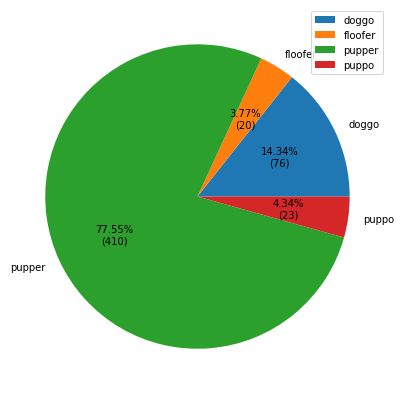

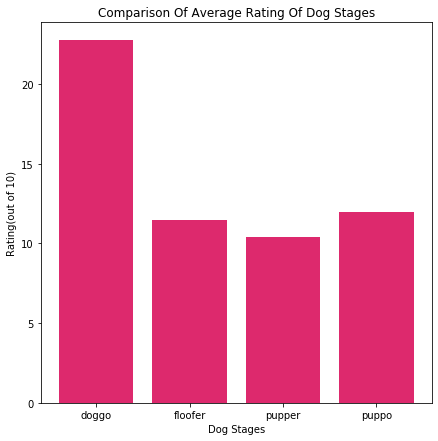

In [115]:
# Plot a pie chart with legend for showing percentage of dogs belonging to different dog stages
plt.figure(figsize = (7, 7))
plt.pie(dog_count, labels = avg_rating.index.values, autopct = lambda pct: func(pct, dog_count))
plt.legend()

# Plot a bar chart with title, xlabel and ylabel for comparison of average rating Of dog stages
plt.figure(figsize = (7, 7))
plt.bar(avg_rating.index.values, avg_rating, 0.8, color = '#DD296D', alpha = 1)
plt.title('Comparison Of Average Rating Of Dog Stages')
plt.xlabel('Dog Stages')
plt.ylabel('Rating(out of 10)')

In [116]:
img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id                        2009 non-null int64
image_url                       2009 non-null object
image_number                    2009 non-null int64
first_prediction                2009 non-null object
first_prediction_confidence     2009 non-null float64
first_prediction_dog            2009 non-null bool
second_prediction               2009 non-null object
second_prediction_confidence    2009 non-null float64
second_prediction_dog           2009 non-null bool
third_prediction                2009 non-null object
third_prediction_confidence     2009 non-null float64
third_prediction_dog            2009 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 162.8+ KB


In [117]:
img_pred_clean.first_prediction.value_counts()

Golden retriever             139
Labrador retriever            95
Pembroke                      88
Chihuahua                     79
Pug                           55
Chow                          41
Samoyed                       40
Pomeranian                    38
Toy poodle                    38
Malamute                      29
Cocker spaniel                27
French bulldog                26
Chesapeake bay retriever      23
Miniature pinscher            22
Seat belt                     21
Siberian husky                20
German shepherd               20
Web site                      19
Staffordshire bullterrier     19
Shetland sheepdog             18
Teddy                         18
Eskimo dog                    18
Maltese dog                   18
Rottweiler                    17
Shih-tzu                      17
Cardigan                      17
Beagle                        17
Lakeland terrier              16
Italian greyhound             16
Kuvasz                        16
          

### 3. Algorithm's First Prediction Efficiency for top 10 most frequent predictions

In [118]:
# Create a subset of the img_pred_clean with the required variables
pred_eff = img_pred_clean[['tweet_id', 'first_prediction', 'first_prediction_confidence', 'first_prediction_dog']].copy()

In [119]:
# See the first five rows of the subset
pred_eff.head()

,tweet_id,first_prediction,first_prediction_confidence,first_prediction_dog
0,666020888022790149,Welsh springer spaniel,0.465074,True
1,666029285002620928,Redbone,0.506826,True
2,666033412701032449,German shepherd,0.596461,True
3,666044226329800704,Rhodesian ridgeback,0.408143,True
4,666049248165822465,Miniature pinscher,0.560311,True


In [120]:
# Store the value counts of 10 most frequent predictions in a seperate variable
total_predictions = pred_eff.first_prediction.value_counts().head(10).values
total_predictions

array([139,  95,  88,  79,  55,  41,  40,  38,  38,  29], dtype=int64)

In [121]:
# Store the prediction names of 10 most frequent predictions in a seperate variable
prediction_names = pred_eff.first_prediction.value_counts().head(10).index.values
prediction_names

array(['Golden retriever', 'Labrador retriever', 'Pembroke', 'Chihuahua',
       'Pug', 'Chow', 'Samoyed', 'Pomeranian', 'Toy poodle', 'Malamute'],
      dtype=object)

In [122]:
# Store the instances when algorithm's first prediction has been successful in a list
true_counts = []
for item in prediction_names:
    x = pred_eff[(pred_eff.first_prediction == item) & (pred_eff.first_prediction_confidence > 0.5) & (pred_eff.first_prediction_dog == True)]['first_prediction_confidence'].count()
    true_counts.append(x)
true_counts

[116, 65, 70, 47, 44, 26, 30, 29, 24, 18]

In [123]:
# Create a dataframe for the above 3 new variables
eff_dict = {'prediction_name': prediction_names, 'prediction_total':total_predictions, 'prediction_correct':true_counts}
eff_result = pd.DataFrame(eff_dict, columns=['prediction_name', 'prediction_total', 'prediction_correct'])
eff_result

,prediction_name,prediction_total,prediction_correct
0,Golden retriever,139,116
1,Labrador retriever,95,65
2,Pembroke,88,70
3,Chihuahua,79,47
4,Pug,55,44
5,Chow,41,26
6,Samoyed,40,30
7,Pomeranian,38,29
8,Toy poodle,38,24
9,Malamute,29,18


In [124]:
# Calculate the prediction efficiency in a seperate column
eff_result['prediction_efficiency(in %)'] = (eff_result['prediction_correct'] / eff_result['prediction_total'])*100
eff_result

,prediction_name,prediction_total,prediction_correct,prediction_efficiency(in %)
0,Golden retriever,139,116,83.453237
1,Labrador retriever,95,65,68.421053
2,Pembroke,88,70,79.545455
3,Chihuahua,79,47,59.493671
4,Pug,55,44,80.000000
5,Chow,41,26,63.414634
6,Samoyed,40,30,75.000000
7,Pomeranian,38,29,76.315789
8,Toy poodle,38,24,63.157895
9,Malamute,29,18,62.068966
